In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

In [2]:
df = pd.read_csv(r'../Final Data/Final_Data.csv')
wheat_price = pd.read_csv(r'../Cleaned Data/Wheat_Price_FRED_clean.csv')
wheat_price = wheat_price.rename(columns={"PWHEAMTUSDM": "Wheat_Price"})
df = pd.merge(df, wheat_price[['observation_date', 'Wheat_Price']], left_on='date', right_on='observation_date', how='left').drop(['observation_date','wheat_price'], axis=1).rename(columns={'Wheat_Price': 'wheat_price'})

In [3]:
df['date'] = pd.to_datetime(df['date'])
exclude_cols = ['date', 'avg_temp', 'drought_idx']
cols_to_logret = [col for col in df.columns if col not in exclude_cols]
logret_df = df[['date']].copy()
for col in cols_to_logret:
    logret_df[col + '_logret'] = (np.log(df[col]) - np.log(df[col].shift(1)))*100

logret_df['avg_temp'] = df['avg_temp']
logret_df['drought_idx'] = df['drought_idx']
logret_df['wheat_price_logret_future'] = logret_df['wheat_price_logret'].shift(-1)
logret_df = logret_df.dropna()
logret_df.head()

,date,fertilizer_idx_logret,cpi_logret,commodity_imp_idx_logret,commodity_exp_idx_logret,flour_price_logret,corn_price_logret,crude_oil_price_logret,wheat_price_logret,avg_temp,drought_idx,wheat_price_logret_future
1,1990-02-01,4.862365,0.391390,0.215983,-0.632247,-1.593659,0.371031,-3.335866,-4.246455,-1.965352,14.6,-2.777957
2,1990-03-01,-0.417189,0.467655,-0.324149,0.211193,1.197619,3.278994,-8.098541,-2.777957,4.222106,11.2,1.860522
3,1990-04-01,-0.418937,0.233010,-0.869571,0.315956,-0.397615,7.589858,-10.106481,1.860522,9.391660,8.0,-6.669145
4,1990-05-01,-2.809891,0.155039,-0.437637,0.210084,1.188133,2.298939,-1.255818,-6.669145,13.738063,7.1,-9.555649
5,1990-06-01,-2.980063,0.617763,-0.439561,-0.210084,1.949379,-0.978787,-8.601287,-9.555649,19.995775,7.3,-8.185102


In [4]:
logret_df =  logret_df.set_index("date")   

In [5]:
logret_df_train_data = logret_df.loc[:'2018-01-01']

logret_df_test_data = logret_df.loc['2018-02-01':]

model_wheat = AutoReg(logret_df_train_data["wheat_price_logret_future"], lags=4,
                      exog= logret_df_train_data[['corn_price_logret','drought_idx','fertilizer_idx_logret','commodity_imp_idx_logret']]).fit()

# Forecasting
forecast_steps = len(logret_df_test_data)  # Forecast length same as test data

forecast_result = model_wheat.get_prediction(start=len(logret_df_train_data), end=len(logret_df_train_data) + forecast_steps - 1, 
                                              exog_oos = logret_df_test_data[['corn_price_logret','drought_idx','fertilizer_idx_logret','commodity_imp_idx_logret']])
forecast_result_mean  = forecast_result.predicted_mean  # Point forecasts
# Confidence intervals (By default, the confidence intervals returned by get_prediction().conf_int() in statsmodels are 95%)
forecast_result_conf_int = forecast_result.conf_int()
print("Predicted values:\n", forecast_result_mean)
print("Confidence intervals:\n", forecast_result_conf_int)

Predicted values:
 2018-02-01    2.607461
2018-03-01   -0.374686
2018-04-01   -0.445377
2018-05-01   -0.059316
2018-06-01    0.789687
                ...   
2024-08-01   -0.796184
2024-09-01   -0.254983
2024-10-01   -0.352061
2024-11-01    0.603212
2024-12-01    0.227903
Freq: MS, Name: predicted_mean, Length: 83, dtype: float64
Confidence intervals:
                 lower      upper
2018-02-01 -10.048162  15.263084
2018-03-01 -13.421846  12.672474
2018-04-01 -13.493786  12.603032
2018-05-01 -13.117388  12.998756
2018-06-01 -12.283268  13.862641
...               ...        ...
2024-08-01 -13.871402  12.279034
2024-09-01 -13.330201  12.820235
2024-10-01 -13.427279  12.723157
2024-11-01 -12.472006  13.678430
2024-12-01 -12.847315  13.303121

[83 rows x 2 columns]


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


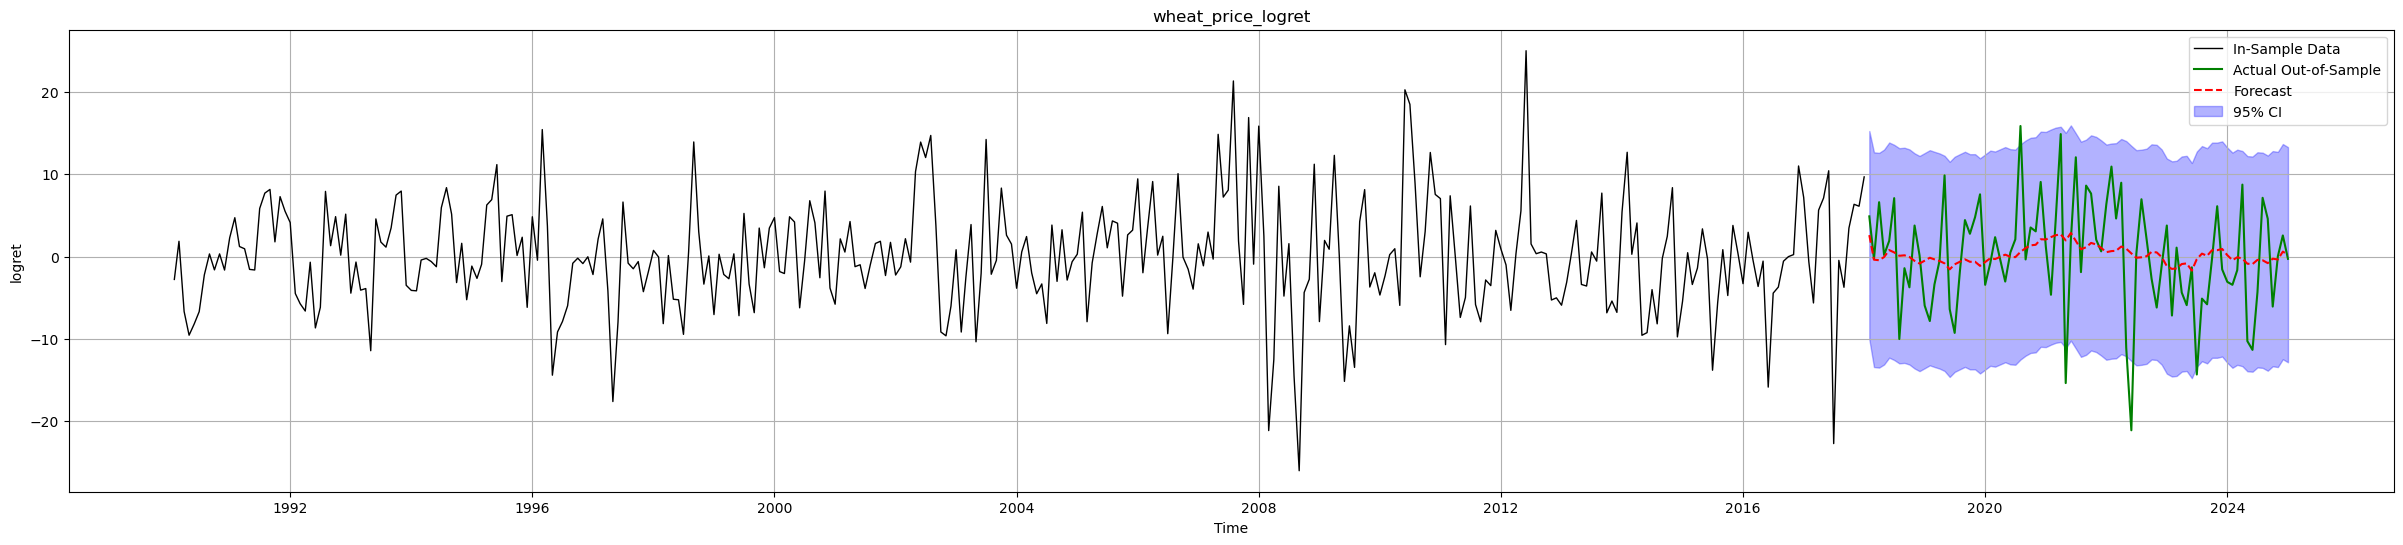

In [6]:
# Plot actual vs forecasted values
plt.figure(figsize=(30, 6))
plt.plot(logret_df_train_data.index, logret_df_train_data["wheat_price_logret_future"], label="In-Sample Data", color="black", linewidth=1)
plt.plot(logret_df_test_data.index, logret_df_test_data["wheat_price_logret_future"], label="Actual Out-of-Sample", color="green", linestyle="solid")
plt.plot(logret_df_test_data.index, forecast_result_mean, label="Forecast", color="red", linestyle="dashed")
# Plot confidence intervals
plt.fill_between(logret_df_test_data.index, forecast_result_conf_int.lower, forecast_result_conf_int.upper, color="blue", alpha=0.3, label="95% CI")

# Formatting
plt.xlabel("Time")
plt.ylabel("logret")
plt.title("wheat_price_logret")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [7]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

best_aic = float('inf')
best_order = None

for p in range(3):
    for d in range(2):
        for q in range(3):
            try:
                arima_model_wheat = ARIMA(logret_df["wheat_price_logret_future"], order=(p,d,q),
                                          exog= logret_df[['corn_price_logret','drought_idx','fertilizer_idx_logret','commodity_imp_idx_logret']]).fit()
                if arima_model_wheat.aic < best_aic:
                    best_aic = arima_model_wheat.aic
                    best_order = (p, d, q)
            except:
                continue
                
print(f"Best ARIMA order: {best_order}")
best_arima = ARIMA(logret_df["wheat_price_logret_future"], order = best_order,
                   exog= logret_df[['corn_price_logret','drought_idx','fertilizer_idx_logret','commodity_imp_idx_logret']]).fit()
print('\n',best_arima.summary())

Best ARIMA order: (1, 0, 2)

                                    SARIMAX Results                                   
Dep. Variable:     wheat_price_logret_future   No. Observations:                  419
Model:                        ARIMA(1, 0, 2)   Log Likelihood               -1370.513
Date:                       Sat, 10 May 2025   AIC                           2759.025
Time:                               10:15:41   BIC                           2795.366
Sample:                                    0   HQIC                          2773.390
                                       - 419                                         
Covariance Type:                         opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.9438      0.369     -2.561      0.010      -1.666      -0.221
cor

In [8]:
arima_train=ARIMA(logret_df_train_data["wheat_price_logret_future"], order = best_order,
                   exog= logret_df_train_data[['corn_price_logret','drought_idx','fertilizer_idx_logret','commodity_imp_idx_logret']]).fit()
arima_forecast = arima_train.get_prediction(start=len(logret_df_train_data), end=len(logret_df_train_data) + forecast_steps - 1, 
                                              exog = logret_df_test_data[['corn_price_logret','drought_idx','fertilizer_idx_logret','commodity_imp_idx_logret']])
arima_forecast_result_mean  = arima_forecast.predicted_mean  # Point forecasts
# Confidence intervals (By default, the confidence intervals returned by get_prediction().conf_int() in statsmodels are 95%)
arima_forecast_result_conf_int = arima_forecast.conf_int()
print("Predicted values:\n", arima_forecast_result_mean)
print("Confidence intervals:\n", arima_forecast_result_conf_int)

Predicted values:
 2018-02-01    3.155446
2018-03-01   -0.211028
2018-04-01    0.192964
2018-05-01    0.359572
2018-06-01    1.187275
                ...   
2024-08-01   -1.172696
2024-09-01   -0.250114
2024-10-01   -0.644754
2024-11-01    0.780504
2024-12-01   -0.183072
Freq: MS, Name: predicted_mean, Length: 83, dtype: float64
Confidence intervals:
             lower wheat_price_logret_future  upper wheat_price_logret_future
2018-02-01                        -9.482054                        15.792946
2018-03-01                       -13.313582                        12.891526
2018-04-01                       -12.912268                        13.298196
2018-05-01                       -12.745669                        13.464813
2018-06-01                       -11.917966                        14.292516
...                                     ...                              ...
2024-08-01                       -14.277937                        11.932545
2024-09-01                    

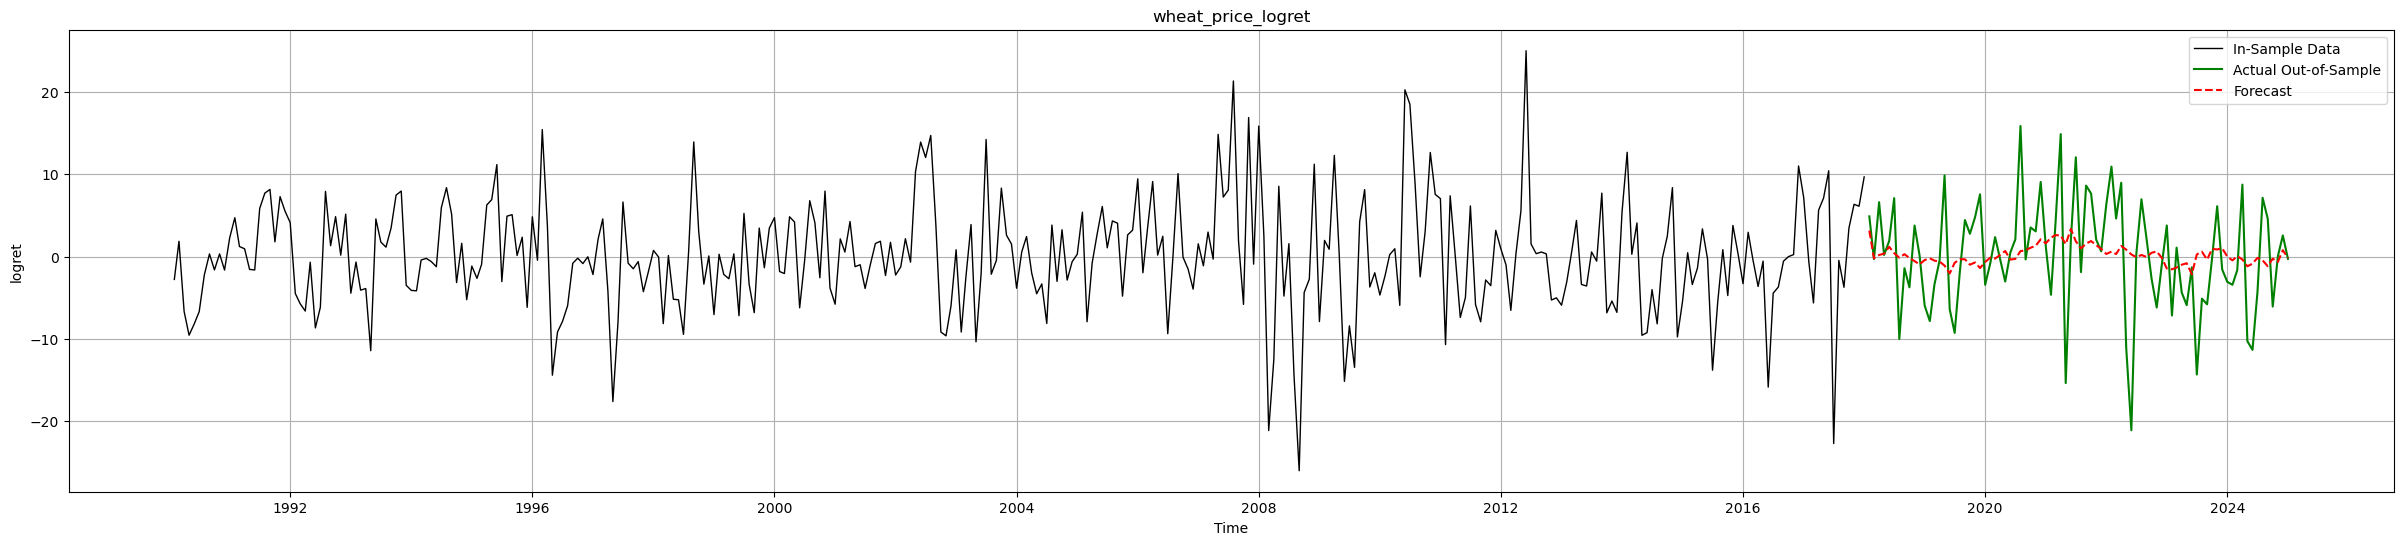

In [9]:
plt.figure(figsize=(30, 6))
plt.plot(logret_df_train_data.index, logret_df_train_data["wheat_price_logret_future"], label="In-Sample Data", color="black", linewidth=1)
plt.plot(logret_df_test_data.index, logret_df_test_data["wheat_price_logret_future"], label="Actual Out-of-Sample", color="green", linestyle="solid")
plt.plot(logret_df_test_data.index, arima_forecast_result_mean, label="Forecast", color="red", linestyle="dashed")

# Formatting
plt.xlabel("Time")
plt.ylabel("logret")
plt.title("wheat_price_logret")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

best_aic = float('inf')
best_order = None
best_seasonal = None

for P in range(2):
    for D in range(2):
        for Q in range(2):
            for p in range(3):
                for d in range(2):
                    for q in range(3):
                        try:
                            sarimax_model_wheat = SARIMAX(logret_df["wheat_price_logret_future"], order=(p,d,q),seasonal_order=(P, D, Q, 12),
                                          exog= logret_df[['corn_price_logret','drought_idx','fertilizer_idx_logret','commodity_imp_idx_logret']]).fit(disp=False)
                            if sarimax_model_wheat.aic < best_aic:
                                best_aic = sarimax_model_wheat.aic
                                best_order = (p, d, q)
                                best_seasonal = (P,D,Q,12)
                        except:
                            continue

print(f"Best SARIMAX order: {best_order}x{best_seasonal}")
best_sarimax = SARIMAX(logret_df["wheat_price_logret"], order = best_order,seasonal_order = best_seasonal,
                   exog= logret_df[['corn_price_logret','drought_idx','fertilizer_idx_logret','commodity_imp_idx_logret']]).fit(disp=False)
print('\n',best_sarimax.summary())

Best SARIMAX order: (1, 0, 2)x(1, 1, 1, 12)

                                       SARIMAX Results                                       
Dep. Variable:                   wheat_price_logret   No. Observations:                  419
Model:             SARIMAX(1, 0, 2)x(1, 1, [1], 12)   Log Likelihood               -1291.961
Date:                              Sat, 10 May 2025   AIC                           2603.923
Time:                                      10:18:10   BIC                           2644.011
Sample:                                           0   HQIC                          2619.787
                                              - 419                                         
Covariance Type:                                opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
corn_price_logret       

In [11]:
sarimax_train=SARIMAX(logret_df_train_data["wheat_price_logret_future"], order = best_order,seasonal_order = best_seasonal,
                   exog= logret_df_train_data[['corn_price_logret','drought_idx','fertilizer_idx_logret','commodity_imp_idx_logret']]).fit(disp=False)
sarimax_forecast = sarimax_train.get_prediction(start=len(logret_df_train_data), end=len(logret_df_train_data) + forecast_steps - 1, 
                                              exog = logret_df_test_data[['corn_price_logret','drought_idx','fertilizer_idx_logret','commodity_imp_idx_logret']])
sarimax_forecast_result_mean  = sarimax_forecast.predicted_mean
# Confidence intervals (By default, the confidence intervals returned by get_prediction().conf_int() in statsmodels are 95%)
sarimax_forecast_result_conf_int = sarimax_forecast.conf_int()
print("Predicted values:\n", sarimax_forecast_result_mean)
print("Confidence intervals:\n", sarimax_forecast_result_conf_int)

Predicted values:
 2018-02-01    3.137997
2018-03-01   -0.969338
2018-04-01    0.259529
2018-05-01   -1.724877
2018-06-01   -0.489738
                ...   
2024-08-01   -0.176818
2024-09-01    0.657587
2024-10-01   -0.429999
2024-11-01    2.458719
2024-12-01    0.291090
Freq: MS, Name: predicted_mean, Length: 83, dtype: float64
Confidence intervals:
             lower wheat_price_logret_future  upper wheat_price_logret_future
2018-02-01                        -9.596757                        15.872751
2018-03-01                       -14.047378                        12.108701
2018-04-01                       -12.839627                        13.358684
2018-05-01                       -14.842830                        11.393076
2018-06-01                       -13.624426                        12.644949
...                                     ...                              ...
2024-08-01                       -13.482978                        13.129343
2024-09-01                    

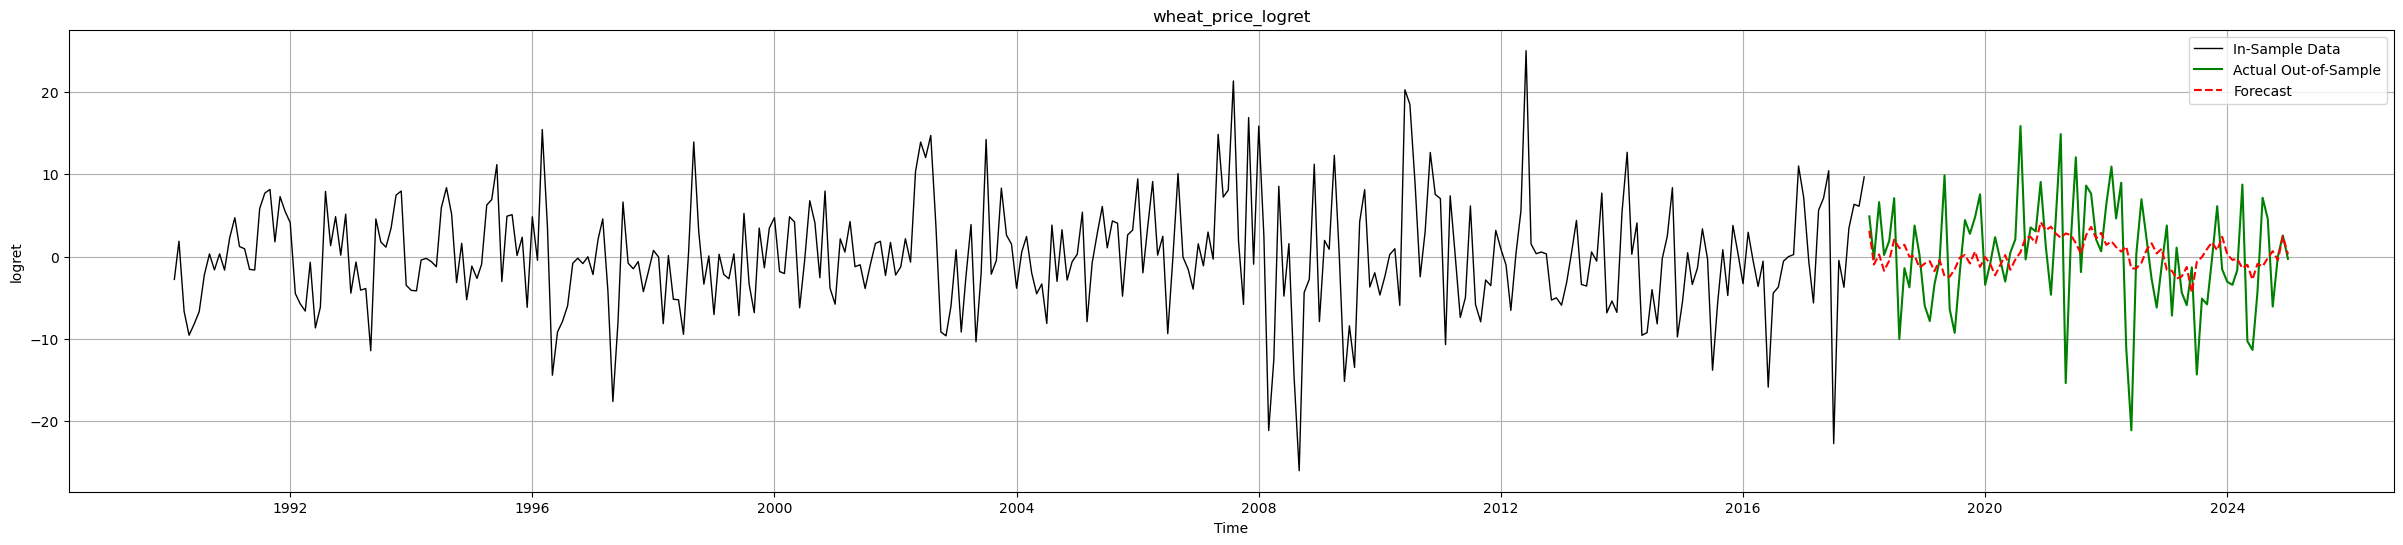

In [12]:
plt.figure(figsize=(30, 6))
plt.plot(logret_df_train_data.index, logret_df_train_data["wheat_price_logret_future"], label="In-Sample Data", color="black", linewidth=1)
plt.plot(logret_df_test_data.index, logret_df_test_data["wheat_price_logret_future"], label="Actual Out-of-Sample", color="green", linestyle="solid")
plt.plot(logret_df_test_data.index, sarimax_forecast_result_mean, label="Forecast", color="red", linestyle="dashed")

# Formatting
plt.xlabel("Time")
plt.ylabel("logret")
plt.title("wheat_price_logret")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [64]:
# Primary variables with multiple lags
primary_vars = ['corn_price_logret','drought_idx','fertilizer_idx_logret','commodity_imp_idx_logret','wheat_price_logret']
primary_lags = [1, 2, 3, 6, 12]  # More comprehensive lag structure

# Secondary variables with fewer lags
secondary_vars = ['crude_oil_price_logret', 'flour_price_logret']
secondary_lags = [1, 3, 6]

df_lagged = logret_df.copy()

# Create lags for primary variables
for var in primary_vars:
    for lag in primary_lags:
        df_lagged[f'{var}_lag_{lag}'] = df_lagged[var].shift(lag)

# Create lags for secondary variables
for var in secondary_vars:
    for lag in secondary_lags:
        df_lagged[f'{var}_lag_{lag}'] = df_lagged[var].shift(lag)

# Drop rows with NaN values (due to lagging)
df_lagged = df_lagged.dropna()
df_lagged.columns

Index(['fertilizer_idx_logret', 'cpi_logret', 'commodity_imp_idx_logret',
       'commodity_exp_idx_logret', 'flour_price_logret', 'corn_price_logret',
       'crude_oil_price_logret', 'wheat_price_logret', 'avg_temp',
       'drought_idx', 'wheat_price_logret_future', 'corn_price_logret_lag_1',
       'corn_price_logret_lag_2', 'corn_price_logret_lag_3',
       'corn_price_logret_lag_6', 'corn_price_logret_lag_12',
       'drought_idx_lag_1', 'drought_idx_lag_2', 'drought_idx_lag_3',
       'drought_idx_lag_6', 'drought_idx_lag_12',
       'fertilizer_idx_logret_lag_1', 'fertilizer_idx_logret_lag_2',
       'fertilizer_idx_logret_lag_3', 'fertilizer_idx_logret_lag_6',
       'fertilizer_idx_logret_lag_12', 'commodity_imp_idx_logret_lag_1',
       'commodity_imp_idx_logret_lag_2', 'commodity_imp_idx_logret_lag_3',
       'commodity_imp_idx_logret_lag_6', 'commodity_imp_idx_logret_lag_12',
       'wheat_price_logret_lag_1', 'wheat_price_logret_lag_2',
       'wheat_price_logret_lag_3', 

In [66]:
lagged_df_train = logret_df.loc[:'2018-01-01']

lagged_df_test = logret_df.loc['2018-02-01':]

X_train = lagged_df_train.drop(columns='wheat_price_logret_future')
X_test = lagged_df_test.drop(columns='wheat_price_logret_future')
y_train = lagged_df_train['wheat_price_logret_future']
y_test = lagged_df_test['wheat_price_logret_future']

In [68]:
from sklearn.tree import DecisionTreeRegressor
dt_model = DecisionTreeRegressor(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [70]:
dt_forecast = dt_model.predict(X_test)
dt_forecast_series = pd.Series(dt_forecast, index=X_test.index, name='forecast')

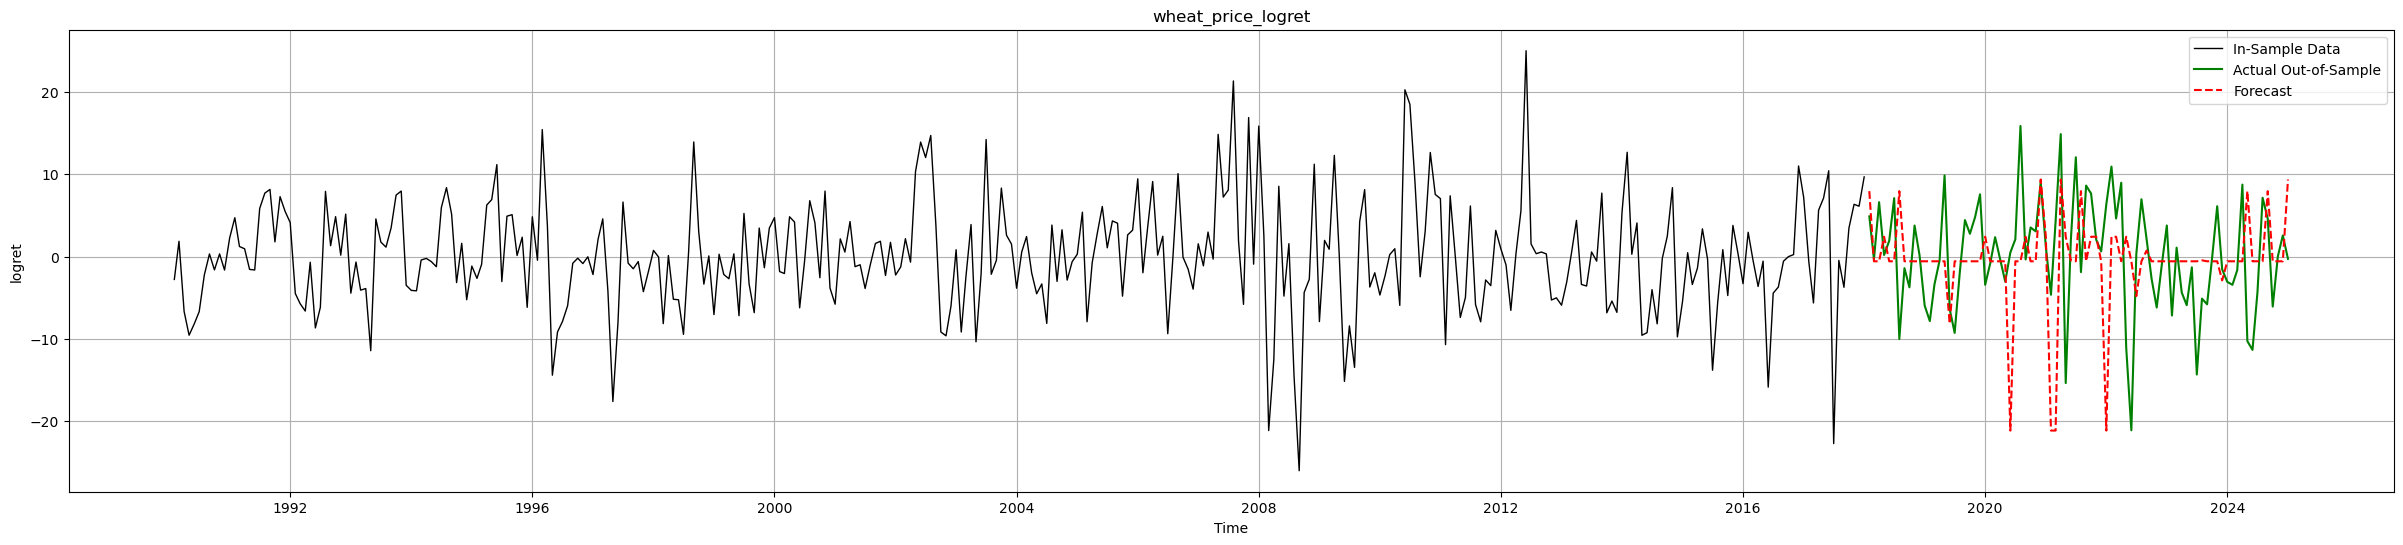

In [72]:
plt.figure(figsize=(30, 6))
plt.plot(logret_df_train_data.index, logret_df_train_data["wheat_price_logret_future"], label="In-Sample Data", color="black", linewidth=1)
plt.plot(logret_df_test_data.index, logret_df_test_data["wheat_price_logret_future"], label="Actual Out-of-Sample", color="green", linestyle="solid")
plt.plot(logret_df_test_data.index, dt_forecast_series, label="Forecast", color="red", linestyle="dashed")

# Formatting
plt.xlabel("Time")
plt.ylabel("logret")
plt.title("wheat_price_logret")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [74]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from xgboost import XGBRegressor
tscv = TimeSeriesSplit(n_splits=5)

# Define parameter grid to search
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)


grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Use negative MSE as the scoring metric
    cv=tscv,                           # Time series cross-validation
    verbose=1,
    n_jobs=-1                          # Use all available cores
).fit(X_train,y_train)

# Perform grid search
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters found: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1.0}


In [75]:
best_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    **best_params
)
best_xgb.fit(X_train, y_train)

# Make predictions
xgb_forecast = best_xgb.predict(X_test)

# Create a Series with the forecast results and the same index as test_data
xgb_forecast_series = pd.Series(xgb_forecast, index=X_test.index, name='forecast')

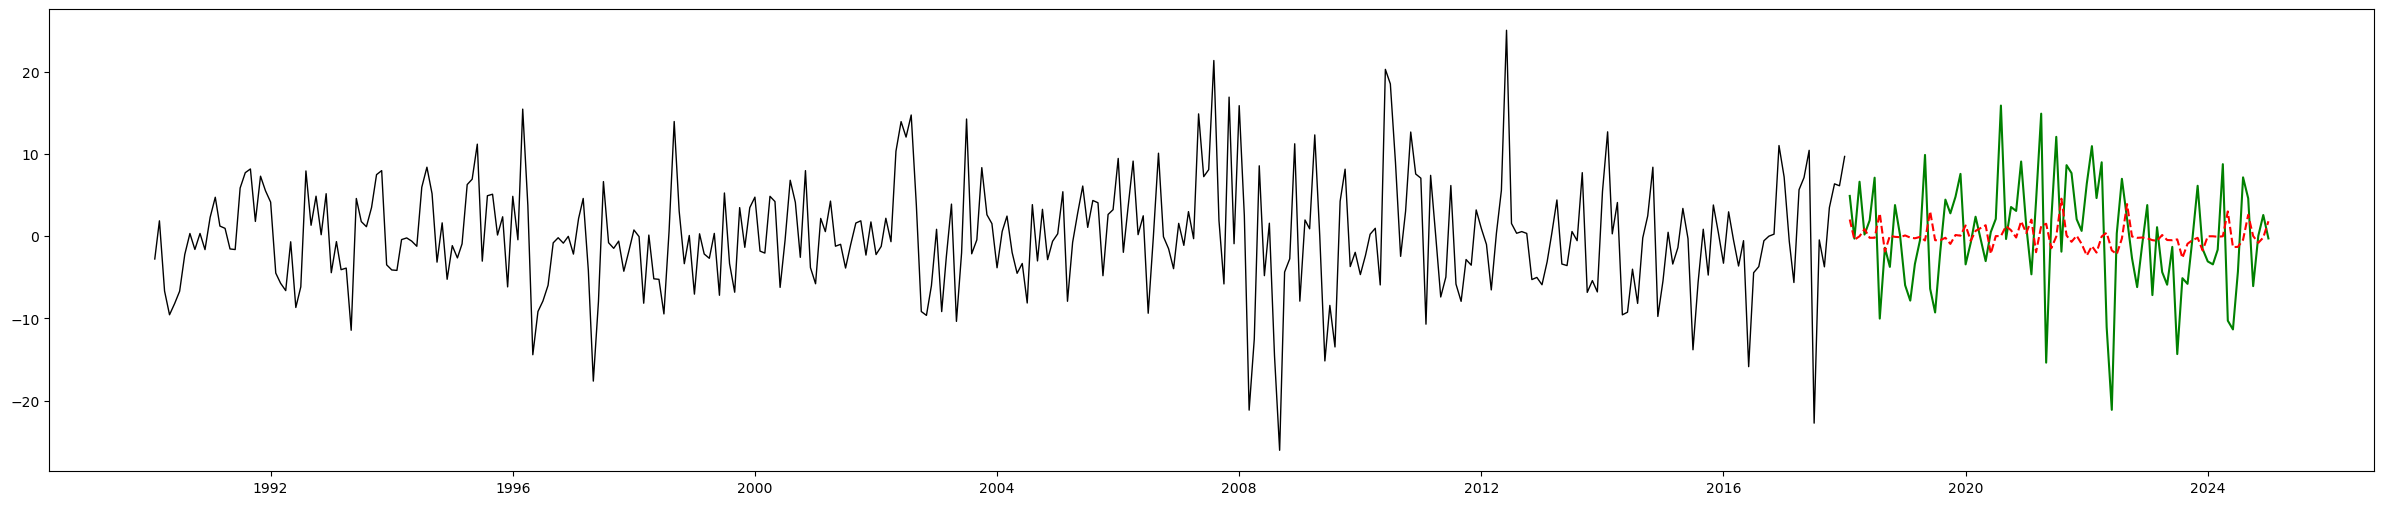

In [76]:
plt.figure(figsize=(30, 6))
plt.plot(logret_df_train_data.index, logret_df_train_data["wheat_price_logret_future"], label="In-Sample Data", color="black", linewidth=1)
plt.plot(logret_df_test_data.index, logret_df_test_data["wheat_price_logret_future"], label="Actual Out-of-Sample", color="green", linestyle="solid")
plt.plot(logret_df_test_data.index, xgb_forecast_series, label="Forecast", color="red", linestyle="dashed")

In [77]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_xgb.feature_importances_
}).sort_values('Importance', ascending=False).head(10)

print("\nTop 10 Most Important Features:")
print(feature_importance)


Top 10 Most Important Features:
                    Feature  Importance
7        wheat_price_logret    0.193240
8                  avg_temp    0.140712
3  commodity_exp_idx_logret    0.129011
2  commodity_imp_idx_logret    0.117812
9               drought_idx    0.092771
5         corn_price_logret    0.086285
6    crude_oil_price_logret    0.074196
1                cpi_logret    0.062645
4        flour_price_logret    0.059871
0     fertilizer_idx_logret    0.043458


In [78]:
actual_values = logret_df_test_data["wheat_price_logret_future"]
forecasts = {
    'AutoReg': forecast_result_mean,
    'ARIMA': arima_forecast_result_mean,
    'SARIMAX': sarimax_forecast_result_mean,
    'Decision Tree': dt_forecast_series,
    'XGBoost': xgb_forecast_series
}

# Calculate metrics
results = []
for model_name, predicted_values in forecasts.items():
    mse = mean_squared_error(actual_values, predicted_values)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_values, predicted_values)
    
    results.append({
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    })
results_df = pd.DataFrame(results).sort_values('RMSE')
results_df

,Model,MSE,RMSE,MAE
2,SARIMAX,41.440526,6.437432,4.985091
1,ARIMA,41.878877,6.471389,4.933361
0,AutoReg,41.963986,6.477962,4.926149
4,XGBoost,47.228234,6.872280,5.371955
3,Decision Tree,74.495874,8.631099,6.229765
